# **NDSI**
Usually when we use a hyperspectral camera we **compare the signal received by the camera** (the reflected radiation at different wavelengths) **and a measurement we made** and try to find the correlations and the mathematical relationship between the two. In my case I have gas exchange measurements measured with the LI-6800 system and I want to find the correlations of the gas exchange rate values (water and carbon dioxide) and the signal received by the camera.

Since each pixel in the camera contains reflected radiation in 204 different wavelengths, we need to process the signal received from the camera and look for which wavelengths correlate to the gas exchange values. 

One of the common methods is to calculate all possible combinations of the values of the normalized distance between two wavelengths using the following formula:

$$\frac{a-b}{a+b}$$


while:

* **a** is the reflectence on 1 wavelengh
* **b** is the reflectence of the other.

In this notebook I will **calculate all the possible combinations between 2 different wavelengths and the correlation of each of them to the gas exchange parameter**.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
# Set the font to Times new roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
from tqdm import tqdm
palette =["deeppink","lime","Orange","forestgreen","red","cyan"]

Define the NDSI function:

In [2]:
def NDSI(x_df, y_df):
    '''
    The NDSI() function takes in two input arguments:
    x_df: a pandas DataFrame with columns representing different bands and rows representing different samples.
    y_df: a pandas DataFrame or Series with the same number of rows as x_df.
    The values in this DataFrame or Series are used to calculate the correlation with the NDSI for each pair of bands in x_df.
    It returns a DataFrame containing the band pair, the correlation and p-value between the NDSI and the second df using spearman correlation and the absolute value of the correlation.
    '''
    # Convert columns names to str
    x_df.columns = x_df.columns.map(str)
    bands_list = x_df.columns

    # All possible pairs of columns
    all_pairs = list(itertools.combinations(bands_list, 2))

    # Calculate the NDSI
    y = y_df.values
    corrs = np.zeros(len(all_pairs))  # array for filling with correlation values
    pvals = np.zeros(len(all_pairs))  # array for filling with p values

    # Use tqdm to show the progress bar
    for index, pair in tqdm(enumerate(all_pairs), total=len(all_pairs), desc="Calculating NDSI"):
        a = x_df[pair[0]].values
        b = x_df[pair[1]].values
        Norm_index = (a-b)/(a+b)
        # Spearman correlation and p value
        corr, pval = stats.spearmanr(Norm_index, y)
        corrs[index] = corr
        pvals[index] = pval

    # Convert to DataFrame
    col1 = [tple[0] for tple in all_pairs]  # column of the first wavelength
    col2 = [tple[1] for tple in all_pairs]  # column of the second wavelength
    index_col = [f"{tple[0]},{tple[1]}" for tple in all_pairs]  # index column
    data = {'band1': col1, "band2": col2, 'Spearman_Corr': corrs, 'p_value': pvals}
    df_results = pd.DataFrame(data=data, index=index_col)
    df_results["Abs_Spearman_Corr"] = df_results["Spearman_Corr"].abs()
    return df_results.sort_values('Abs_Spearman_Corr',ascending=False)


In [3]:
def NDSI_pearson(x_df, y_df):
    '''
    The  NDSI_pearson takes is the same as NDSI()
    but calculate the pearson correlation instead of Spearman correlation
    '''
    # Convert columns names to str
    x_df.columns = x_df.columns.map(str)
    bands_list = x_df.columns

    # All possible pairs of columns
    all_pairs = list(itertools.combinations(bands_list, 2))

    # Calculate the NDSI
    y = y_df.values
    corrs = np.zeros(len(all_pairs))  # array for filling with correlation values
    pvals = np.zeros(len(all_pairs))  # array for filling with p values

    # Use tqdm to show the progress bar
    for index, pair in tqdm(enumerate(all_pairs), total=len(all_pairs), desc="Calculating NDSI"):
        a = x_df[pair[0]].values
        b = x_df[pair[1]].values
        Norm_index = (a-b)/(a+b)
        # Pearson correlation and p value
        corr, pval = stats.pearsonr(Norm_index, y)
        corrs[index] = corr
        pvals[index] = pval

    # Convert to DataFrame
    col1 = [tple[0] for tple in all_pairs]  # column of the first wavelength
    col2 = [tple[1] for tple in all_pairs]  # column of the second wavelength
    index_col = [f"{tple[0]},{tple[1]}" for tple in all_pairs]  # index column
    data = {'band1': col1, "band2": col2, 'Pearson_Corr': corrs, 'p_value': pvals}
    df_results = pd.DataFrame(data=data, index=index_col)
    df_results["Abs_Pearson_Corr"] = df_results["Pearson_Corr"].abs()
    return df_results.sort_values('Abs_Pearson_Corr',ascending=False)

Apply on my data:

In [4]:
path = "/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/licor_hs_final_Scaled.csv"
df = pd.read_csv(path, usecols=lambda column: column not in ["Unnamed: 0"]).dropna()

# remove non relevant rows
df = df.loc[144:].reset_index(drop = True)

# Convert date ro datetime:
df['date'] = pd.to_datetime(df['date'])

df

,Species,date,hhmmss,Leaf,Flir_T,Flir_std,E,A,Ca,Ci,...,981.96,985.05,988.13,991.22,994.31,997.4,1000.49,1003.58,Leaf_hs,date_hs
0,Peperomia,2022-09-29,11:04:45,2,25.829375,0.034055,0.001327,5.847572,397.115633,301.828634,...,0.441516,0.450240,0.449760,0.443553,0.443909,0.457009,0.460289,0.387068,2,9/29/2022
1,Peperomia,2022-09-29,11:10:44,2,25.498917,0.041417,0.000146,1.638208,406.502548,169.206544,...,0.484117,0.495385,0.495417,0.498368,0.497526,0.508085,0.517763,0.419272,2,9/29/2022
2,Peperomia,2022-09-29,11:14:49,2,26.653143,0.049116,0.000085,0.953577,407.750833,168.747443,...,0.636248,0.643773,0.654254,0.649095,0.648976,0.663498,0.664241,0.544591,2,9/29/2022
3,Spathiphyllum,2022-09-29,11:19:49,3,25.481000,0.080629,0.000980,5.276762,398.669581,285.557591,...,0.434571,0.442125,0.450255,0.441328,0.445379,0.446403,0.451556,0.348060,3,9/29/2022
4,Spathiphyllum,2022-09-29,11:23:09,3,25.192621,0.096039,0.002322,7.336335,393.527933,325.077069,...,0.547208,0.561838,0.558166,0.562186,0.553272,0.556904,0.560643,0.454179,3,9/29/2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,Peperomia,2022-11-30,13:40:06,2,23.979500,0.045405,0.000334,4.258127,401.204633,141.388702,...,0.602140,0.605162,0.607050,0.608677,0.616766,0.624557,0.640122,0.535529,20,11/30/2022
322,Spathiphyllum,2022-11-30,13:46:14,3,22.374810,0.049162,0.000235,1.826188,406.244226,247.412986,...,0.333009,0.335900,0.333440,0.338785,0.340509,0.344184,0.340244,0.291364,21,11/30/2022
323,Philodendron,2022-11-30,13:56:40,4,23.815200,0.045284,0.000056,0.933424,408.054742,72.845732,...,0.605555,0.608940,0.612466,0.610417,0.622192,0.624104,0.616393,0.531091,22,11/30/2022
324,Monalisa,2022-11-30,14:14:41,5,23.191700,0.044395,0.000357,2.009618,405.693600,289.063759,...,0.392599,0.392656,0.390289,0.388365,0.387637,0.393369,0.404670,0.359937,23,11/30/2022


In [5]:
results = NDSI(df[df.columns[15:-2]],df['A'])

Calculating NDSI: 100%|██████████| 20706/20706 [00:23<00:00, 868.15it/s] 


In [6]:
results

,band1,band2,Spearman_Corr,p_value,Abs_Spearman_Corr
"400.2,997.4",400.2,997.4,-0.561311,1.857717e-28,0.561311
"400.2,981.96",400.2,981.96,-0.560449,2.338089e-28,0.560449
"400.2,966.55",400.2,966.55,-0.559887,2.715815e-28,0.559887
"400.2,985.05",400.2,985.05,-0.559774,2.798086e-28,0.559774
"400.2,1000.49",400.2,1000.49,-0.559249,3.217216e-28,0.559249
...,...,...,...,...,...
"460.96,708.57",460.96,708.57,0.000074,9.989388e-01,0.000074
"408.85,434.87",408.85,434.87,0.000064,9.990780e-01,0.000064
"481.32,548.55",481.32,548.55,0.000052,9.992569e-01,0.000052
"589.75,675.73",589.75,675.73,0.000023,9.996769e-01,0.000023


As you can see the highest correlation value (according to the Spearman coefficient) is 0.46. **This result is not good enough for us**, so we will try to check two more directions:

1. Instead of calculating a value for each wavelength, we will **perform an average over every few wavelengths (3-5) and check whether in this case the correlation is stronger**. This option is reasonable considering that each wavelength has a very small amount of radiation, so it may be correct to take an average of several wavelengths. We will compare the average value to the gas exchange parameter.
2. We will look for **the correlation between the average value for each species for all wavelengths**. Each sample will actually be an average of all samples for that species.

##**1.  Mean of all every n bands**

In [7]:
n = 4                                          # define how much column to average
x = df[df.columns[15:-2]].to_numpy()           
cols = np.arange(0,205,n)                      # array for index
df_avg = pd.DataFrame()                        # empty df
for index, elem in enumerate(cols):
  if (index+1 < len(cols) and index - 1 >= 0): # without the last time
    data = x[:, elem:cols[index+1]]            # data of the cols
    Avg = data.mean(axis=1)                    # mean
    df_avg[elem] = Avg                         # column of the avg data

df_avg

,4,8,12,16,20,24,28,32,36,40,...,164,168,172,176,180,184,188,192,196,200
0,0.056881,0.043728,0.040705,0.044450,0.042424,0.035355,0.029994,0.030658,0.036706,0.055977,...,0.537993,0.534820,0.534124,0.523935,0.502852,0.474478,0.440301,0.436497,0.446268,0.437069
1,0.063230,0.043360,0.029890,0.022908,0.022765,0.024048,0.023746,0.023098,0.025257,0.037737,...,0.621833,0.618902,0.614702,0.603916,0.572738,0.529206,0.482465,0.479037,0.493321,0.485661
2,0.097909,0.081945,0.074955,0.075924,0.074127,0.068873,0.064740,0.064076,0.068188,0.084734,...,0.812905,0.808877,0.802200,0.787018,0.751398,0.694720,0.637471,0.630216,0.645843,0.630327
3,0.050745,0.041626,0.038494,0.039999,0.038673,0.035623,0.033121,0.032705,0.034552,0.041443,...,0.474545,0.475376,0.475728,0.473188,0.463375,0.452359,0.437045,0.437817,0.442070,0.422850
4,0.060879,0.049122,0.048996,0.055691,0.054375,0.044124,0.036644,0.036881,0.044151,0.065350,...,0.593316,0.594636,0.594739,0.592280,0.581706,0.565277,0.550181,0.546313,0.557349,0.531250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,0.110354,0.085602,0.062809,0.047273,0.048979,0.056547,0.060282,0.058982,0.059340,0.069290,...,0.784712,0.780532,0.773447,0.756322,0.717782,0.656218,0.602591,0.594287,0.605757,0.604243
322,0.046915,0.034850,0.024221,0.019333,0.018585,0.019206,0.018468,0.018010,0.020253,0.028889,...,0.365399,0.366223,0.366843,0.365450,0.358465,0.347193,0.335184,0.333968,0.335284,0.329075
323,0.102409,0.084575,0.074953,0.074035,0.071443,0.066037,0.062909,0.064173,0.075112,0.104376,...,0.679789,0.679468,0.678834,0.673998,0.657647,0.634100,0.609757,0.605512,0.609344,0.598445
324,0.048002,0.035575,0.030192,0.030350,0.029296,0.024160,0.020379,0.019889,0.021840,0.028823,...,0.531635,0.529611,0.524200,0.509094,0.477289,0.433030,0.394192,0.383705,0.390977,0.386404


In [8]:
results_Avg = NDSI(df_avg,df['A'])

Calculating NDSI: 100%|██████████| 1225/1225 [00:00<00:00, 1375.96it/s]


In [9]:
results_Avg

,band1,band2,Spearman_Corr,p_value,Abs_Spearman_Corr
"4,192",4,192,-0.503084,2.570479e-22,0.503084
"4,188",4,188,-0.499842,5.227962e-22,0.499842
"4,196",4,196,-0.498641,6.787601e-22,0.498641
"4,200",4,200,-0.480342,3.201720e-20,0.480342
"40,68",40,68,0.476596,6.850379e-20,0.476596
...,...,...,...,...,...
"72,100",72,100,0.002019,9.710301e-01,0.002019
"152,172",152,172,0.002000,9.712984e-01,0.002000
"32,56",32,56,0.001830,9.737375e-01,0.001830
"28,48",28,48,-0.001376,9.802562e-01,0.001376


Lets average the most correlated bands manually:

In [10]:
# Normalized index
def Avg_nvi_column(df,list1,list2):
  # crete matrix and calculate mean:
  mean1 = df[list1].mean(axis=1).values # mean of raws
  mean2 = df[list2].mean(axis=1).values # mean of raws

  data = (mean1-mean2)/(mean1 + mean2)
  return data 

# fraction index
def Avg_frac_column(df,list1,list2):
  mean1 = df[list1].mean(axis=1).values # mean of raws
  mean2 = df[list2].mean(axis=1).values # mean of raws
  data = mean1/mean2
  return data 

In [11]:
bands = np.arange(0,204,1)
wavelength = [397.32, 400.2, 403.09, 405.97, 408.85, 411.74, 414.63, 417.52, 420.4, 423.29, 426.19, 429.08, 431.97, 434.87, 437.76, 440.66, 443.56, 446.45, 449.35, 452.25, 455.16, 458.06, 460.96, 463.87, 466.77, 469.68, 472.59, 475.5, 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 498.8, 501.72, 504.64, 507.56, 510.48, 513.4, 516.33, 519.25, 522.18, 525.1, 528.03, 530.96, 533.89, 536.82, 539.75, 542.68, 545.62, 548.55, 551.49, 554.43, 557.36, 560.3, 563.24, 566.18, 569.12, 572.07, 575.01, 577.96, 580.9, 583.85, 586.8, 589.75, 592.7, 595.65, 598.6, 601.55, 604.51, 607.46, 610.42, 613.38, 616.34, 619.3, 622.26, 625.22, 628.18, 631.15, 634.11, 637.08, 640.04, 643.01, 645.98, 648.95, 651.92, 654.89, 657.87, 660.84, 663.81, 666.79, 669.77, 672.75, 675.73, 678.71, 681.69, 684.67, 687.65, 690.64, 693.62, 696.61, 699.6, 702.58, 705.57, 708.57, 711.56, 714.55, 717.54, 720.54, 723.53, 726.53, 729.53, 732.53, 735.53, 738.53, 741.53, 744.53, 747.54, 750.54, 753.55, 756.56, 759.56, 762.57, 765.58, 768.6, 771.61, 774.62, 777.64, 780.65, 783.67, 786.68, 789.7, 792.72, 795.74, 798.77, 801.79, 804.81, 807.84, 810.86, 813.89, 816.92, 819.95, 822.98, 826.01, 829.04, 832.07, 835.11, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 865.5, 868.55, 871.6, 874.64, 877.69, 880.74, 883.79, 886.84, 889.9, 892.95, 896.01, 899.06, 902.12, 905.18, 908.24, 911.3, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 938.88, 941.95, 945.02, 948.1, 951.17, 954.24, 957.32, 960.4, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22, 994.31, 997.4, 1000.49, 1003.58]
bands_to_wl = dict(zip(bands, wavelength))

In [12]:
list1 = ['951.17', '954.24', '957.32', '960.4', '963.47']		
list2 = ['997.4','1000.49','1003.58']
top_corr = Avg_nvi_column(df,list1,list2)
stats.spearmanr(top_corr, df['A'].values)[0]

0.3814856410545046

No big difference😞


## **2. Group by Species**

### **Photosynthesis Rate** (An)

In [13]:
df_group_avg = df.groupby('Species').mean()
# Sort by species (for palette later)
df_group_avg.index = df_group_avg.index.str.strip()
df_group_avg = df_group_avg.reindex(['Tradescantia', 'Peperomia', 'Spathiphyllum', 'Philodendron', 'Monalisa', 'Chlorophytum'])
df_group_avg

,Leaf,Flir_T,Flir_std,E,A,Ca,Ci,gsw,Qin,Qamb_out,...,978.88,981.96,985.05,988.13,991.22,994.31,997.4,1000.49,1003.58,Leaf_hs
Species,,,,,,,,,,,,,,,,,,,,,
Tradescantia,1.000000,23.671803,0.047283,0.000176,2.620502,404.416809,35.275792,0.014567,64.450436,72.516931,...,0.592401,0.594037,0.597014,0.601666,0.607877,0.612669,0.618140,0.625955,0.535575,3.250000
Peperomia,2.000000,24.059368,0.057429,0.000347,2.955031,404.012666,-17.771170,0.028382,76.356662,83.400767,...,0.569595,0.572146,0.576389,0.580555,0.585616,0.590603,0.599778,0.605658,0.505267,5.763636
Spathiphyllum,3.036364,23.296048,0.076527,0.000839,5.229538,399.360835,217.295602,0.070182,76.006240,84.073807,...,0.624790,0.624665,0.627043,0.628396,0.630287,0.632476,0.635105,0.637425,0.520585,8.436364
Philodendron,4.072727,23.948786,0.500526,0.000218,3.101990,403.766933,-76.643823,0.017704,56.972808,62.582519,...,0.609939,0.612182,0.612812,0.618224,0.620281,0.623561,0.626813,0.630168,0.520564,11.109091
Monalisa,4.888889,23.643554,0.052089,0.000601,2.704105,404.104837,259.078104,0.050465,33.942023,40.660130,...,0.512788,0.515807,0.517449,0.523194,0.525669,0.531636,0.537333,0.542126,0.468056,13.574074
Chlorophytum,6.000000,22.800122,0.059290,0.000422,1.631565,406.443882,-210.861863,0.034206,25.962576,29.158036,...,0.390489,0.391030,0.392393,0.395694,0.397255,0.400338,0.402856,0.406317,0.348662,16.309091


In [14]:
ndsi_grouop = NDSI_pearson(df_group_avg[df_group_avg.columns[12:-2]],df_group_avg['A']) #wl vs A
ndsi_grouop

Calculating NDSI: 100%|██████████| 20503/20503 [00:01<00:00, 12686.43it/s]


,band1,band2,Pearson_Corr,p_value,Abs_Pearson_Corr
"801.79,804.81",801.79,804.81,0.973229,0.001065,0.973229
"795.74,804.81",795.74,804.81,0.928827,0.007418,0.928827
"798.77,804.81",798.77,804.81,0.913586,0.010878,0.913586
"801.79,807.84",801.79,807.84,0.899448,0.014658,0.899448
"795.74,807.84",795.74,807.84,0.896287,0.015577,0.896287
...,...,...,...,...,...
"774.62,923.55",774.62,923.55,0.000502,0.999248,0.000502
"420.4,519.25",420.4,519.25,-0.000495,0.999257,0.000495
"807.84,838.14",807.84,838.14,-0.000403,0.999396,0.000403
"501.72,595.65",501.72,595.65,-0.000269,0.999597,0.000269


1. Take just Correlation above 0.8.
2. Just bands with difference of n nanometers.

In [15]:
sort_An = ndsi_grouop[ndsi_grouop['Abs_Pearson_Corr']>=0.8] # correlation above 0.8
sort_An['band1'] = pd.to_numeric(sort_An['band1'])
sort_An['band2'] = pd.to_numeric(sort_An['band2'])
sort_An['diff_bands'] = sort_An['band1']-sort_An['band2'] # Difference between wl
sort_An['diff_bands'] = sort_An['diff_bands'].abs() #absulute values
n = 30 # set the difference between wl:
# sort_An[sort_An['diff_bands']>n]
sort_An

<ipython-input-15-5812d1c6ead9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sort_An['band1'] = pd.to_numeric(sort_An['band1'])
<ipython-input-15-5812d1c6ead9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sort_An['band2'] = pd.to_numeric(sort_An['band2'])
<ipython-input-15-5812d1c6ead9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,band1,band2,Pearson_Corr,p_value,Abs_Pearson_Corr,diff_bands
"801.79,804.81",801.79,804.81,0.973229,0.001065,0.973229,3.02
"795.74,804.81",795.74,804.81,0.928827,0.007418,0.928827,9.07
"798.77,804.81",798.77,804.81,0.913586,0.010878,0.913586,6.04
"801.79,807.84",801.79,807.84,0.899448,0.014658,0.899448,6.05
"795.74,807.84",795.74,807.84,0.896287,0.015577,0.896287,12.10
...,...,...,...,...,...,...
"789.7,813.89",789.70,813.89,0.804429,0.053632,0.804429,24.19
"985.05,988.13",985.05,988.13,0.803695,0.054021,0.803695,3.08
"403.09,960.4",403.09,960.40,-0.802586,0.054612,0.802586,557.31
"403.09,988.13",403.09,988.13,-0.802222,0.054806,0.802222,585.04


In [16]:
def plot_2bands(df,band1,band2,y_col):
    
    '''
    This function plots a scatter plot of two bands of interest and y column of interest
    and it plots the linear regression line along with the correlation coefficient and p-value.
    '''  

    # Set the theme for the plot
    palette =["deeppink","lime","Orange","forestgreen","red","cyan"]
    sns.set_theme(style="white",font_scale = 1.5, palette=palette)
    
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(1, figsize=(6,4))

    # Calculate the normalized index
    NI = (df[band1]-df[band2])/(df[band1]+df[band2])
    x = NI
    y = df[y_col]

    # Get only the non-NaN values
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
    r2 =  round(r_value**2,2)
    
    # Create the scatter plot (colors by species)
    colors = df_group_avg.index 
    ax = sns.scatterplot(data=df, x=x[mask], y=y[mask],s=200, hue=colors, edgecolors='black', palette=palette)
    # Create the regression line
    ax = sns.lineplot(x=x[mask], y=x[mask]*slope+intercept, color="black", lw=3,
                     label=f"$R^2$ = {r2} \n p = {round(p_value,2)} ")
    # Set the x and y labels
    ax.set_xlabel("NDSI: "+ band1+" Vs "+band2, fontsize=15)
    ax.set_ylabel(y_col, fontsize=15)
    ax.set_title("NDSI", fontsize=20)
    ax.xaxis.set_tick_params(rotation=90)
    plt.legend(loc=6, bbox_to_anchor=(1.05, 0.5), fontsize=14)
    # Show the plot
    plt.show()

Plot the bands on graph function:

In [17]:
def plot_lines(band1,band2,xticks_diff=20):
    # Create a figure and axis for the plot
    fig, ax = plt.subplots(1, figsize=(6,4))
   
    # Iterate through each row of the grouped DataFrame
    for species, row in df_group_avg.iterrows():
        ax.plot(df_group_avg.columns[12:-2], row[12:-2], label=species)
    # Specify the ticks to be displayed
    plt.xticks(df.columns[15:-2][::xticks_diff],  rotation='vertical')
    # Add a vertical line at the specified band1 and band2 values
    ax.axvline(x=band1, color='black', lw=2, ls='--', label=band1)
    ax.axvline(x=band2, color='black', lw=2, label=band2)
    # Create a legend for the plot
    plt.legend(loc=6, bbox_to_anchor=(1.05, 0.5),fontsize=12)
    # Show the plot
    plt.show()
    return

#### **Plots**

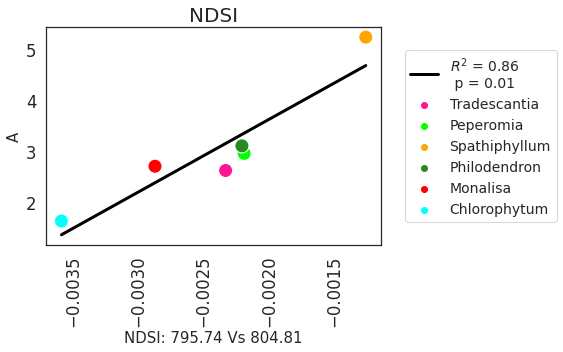

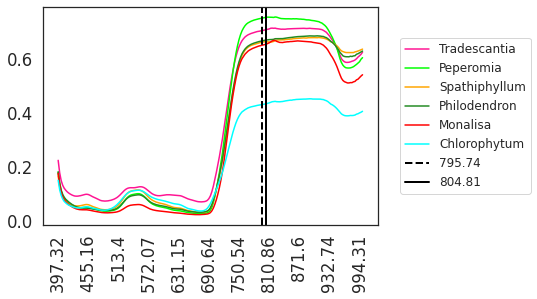

In [18]:
plot_2bands(df_group_avg,'795.74','804.81','A')
plot_lines('795.74','804.81')

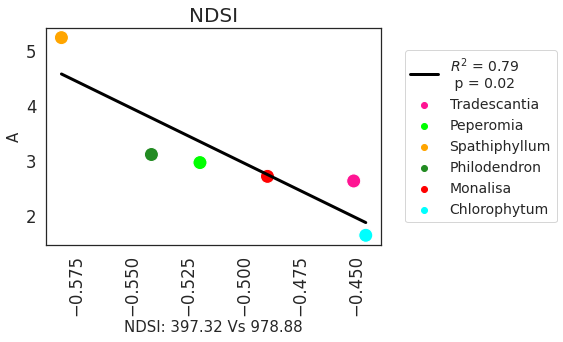

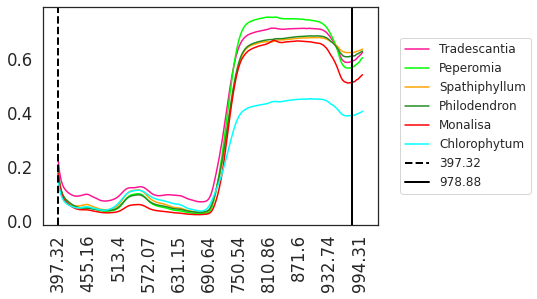

In [19]:
plot_2bands(df_group_avg,'397.32','978.88','A')
plot_lines('397.32','978.88')	

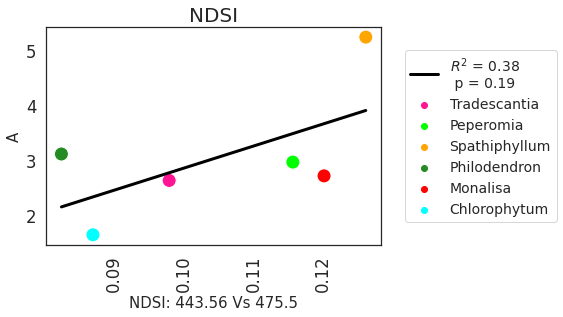

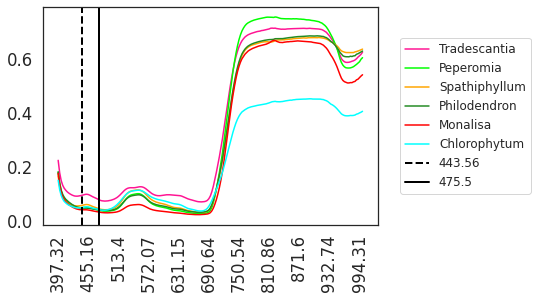

In [20]:
plot_2bands(df_group_avg,'443.56','475.5','A')
plot_lines('443.56','475.5')

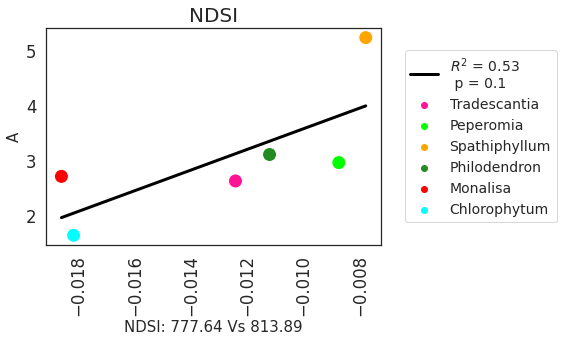

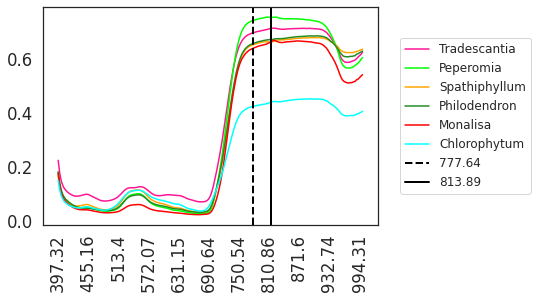

In [21]:
plot_2bands(df_group_avg,'777.64','813.89','A')
plot_lines('777.64','813.89')
	

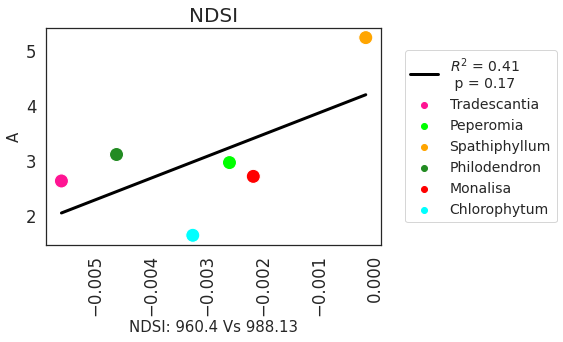

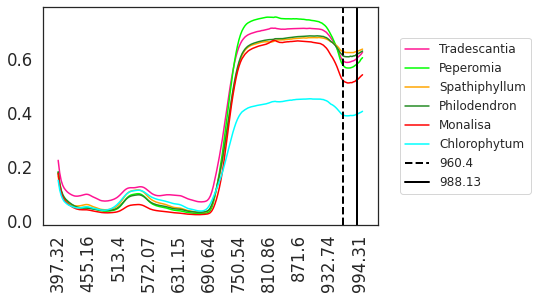

In [22]:
plot_2bands(df_group_avg,'960.4','988.13','A')
plot_lines('960.4','988.13')
	

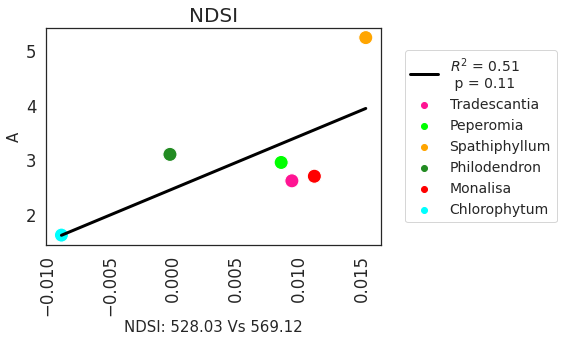

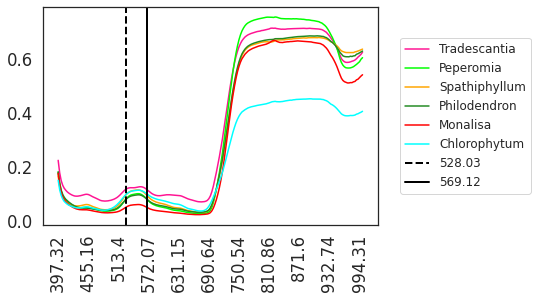

In [23]:
plot_2bands(df_group_avg,'528.03','569.12','A')
plot_lines('528.03','569.12')

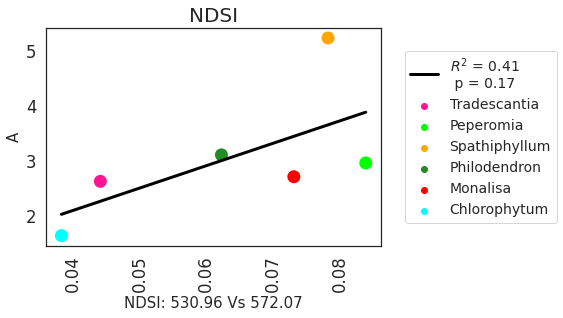

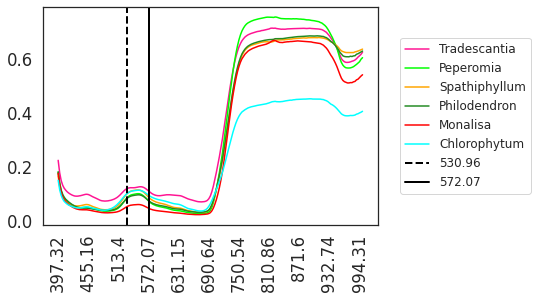

In [24]:
plot_2bands(df_group_avg,'530.96','572.07','A')
plot_lines('530.96','572.07')

### **Transpiration Rate** (E)

Here also I will group the data by Species:

In [25]:
ndsi_grouop_e = NDSI_pearson(df_group_avg[df_group_avg.columns[12:-2]],df_group_avg['E'])
ndsi_grouop_e

Calculating NDSI: 100%|██████████| 20503/20503 [00:01<00:00, 11292.20it/s]


,band1,band2,Pearson_Corr,p_value,Abs_Pearson_Corr
"960.4,988.13",960.4,988.13,0.950626,0.003596,0.950626
"963.47,981.96",963.47,981.96,0.931519,0.006874,0.931519
"960.4,991.22",960.4,991.22,0.895495,0.015811,0.895495
"516.33,699.6",516.33,699.6,0.888545,0.017941,0.888545
"539.75,557.36",539.75,557.36,0.886112,0.018717,0.886112
...,...,...,...,...,...
"865.5,892.95",865.5,892.95,-0.000554,0.999169,0.000554
"440.66,589.75",440.66,589.75,0.000537,0.999194,0.000537
"449.35,575.01",449.35,575.01,0.000516,0.999226,0.000516
"420.4,598.6",420.4,598.6,-0.000174,0.999739,0.000174


In [26]:
ndsi_grouop_e[ndsi_grouop_e['Abs_Pearson_Corr']>0.7]

,band1,band2,Pearson_Corr,p_value,Abs_Pearson_Corr
"960.4,988.13",960.4,988.13,0.950626,0.003596,0.950626
"963.47,981.96",963.47,981.96,0.931519,0.006874,0.931519
"960.4,991.22",960.4,991.22,0.895495,0.015811,0.895495
"516.33,699.6",516.33,699.6,0.888545,0.017941,0.888545
"539.75,557.36",539.75,557.36,0.886112,0.018717,0.886112
...,...,...,...,...,...
"452.25,672.75",452.25,672.75,0.700519,0.121104,0.700519
"966.55,978.88",966.55,978.88,0.700474,0.121138,0.700474
"533.89,699.6",533.89,699.6,0.700351,0.121231,0.700351
"810.86,826.01",810.86,826.01,-0.700137,0.121395,0.700137


#### Plots

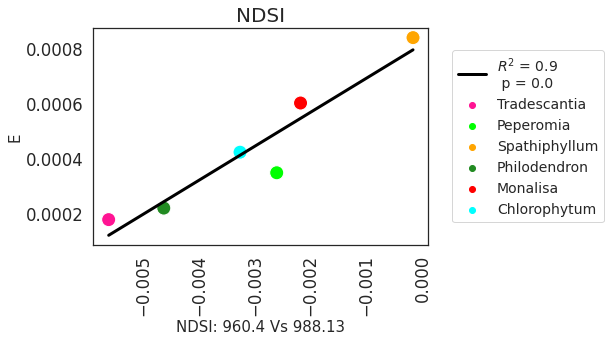

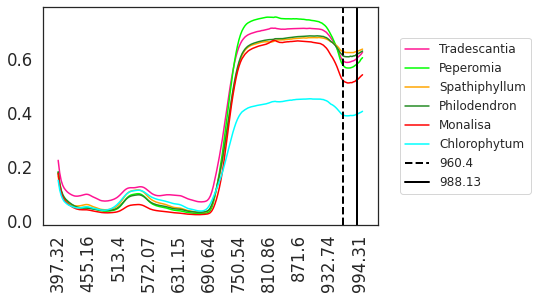

In [27]:
plot_2bands(df_group_avg,'960.4','988.13','E')
plot_lines('960.4','988.13')

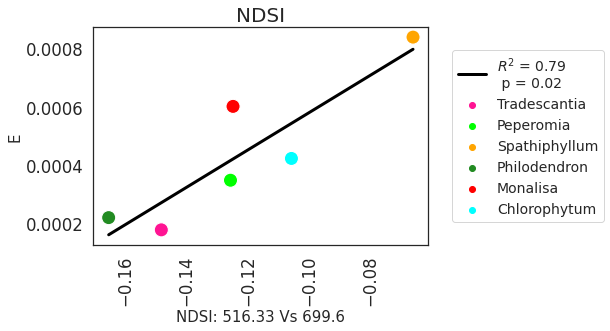

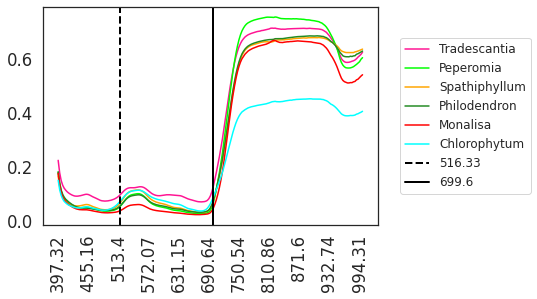

In [28]:
plot_2bands(df_group_avg,'516.33','699.6','E')
plot_lines('516.33','699.6')

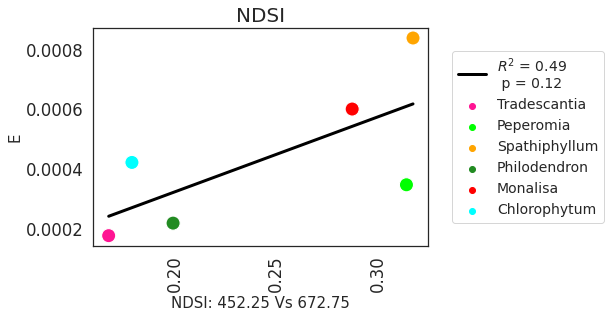

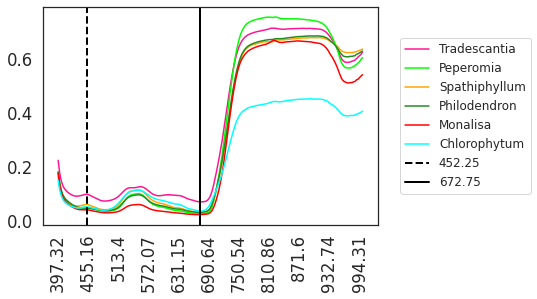

In [30]:
plot_2bands(df_group_avg,'452.25','672.75','E')
plot_lines('452.25','672.75')

In [31]:
def plot_2columns(df,col1,col2):
  fig, ax = plt.subplots(1, figsize=(6,4))
  # parameters:
  colors = df_group_avg.index # colors by species

  x = df[col1]
  y = df[col2]
  mask = ~np.isnan(x) & ~np.isnan(y) #not nan values
  slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
  r2 =  round(r_value**2,2)
  # scatter
  ax = sns.scatterplot(data=df,x=x[mask], y=y[mask],s=200, hue=colors,edgecolors='black',palette=palette)
  # Regression line:
  ax = sns.lineplot(x=x[mask], y=x[mask]*slope+intercept,
                    color = "black",lw = 3,
                    label = f"$R^2$ = {r2} \n p = {round(p_value,2)} ")


  ax.set_xlabel(col1,fontsize=15)
  ax.set_ylabel(col2,fontsize=15)
  ax.set_title(str(col2) + " Vs " + str(col1),fontsize=20)
  plt.legend(loc=6, bbox_to_anchor=(1.05, 0.5),fontsize=14)

  return

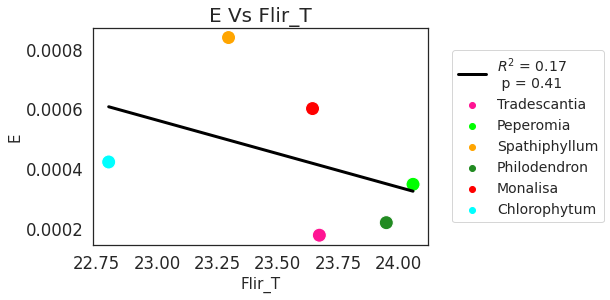

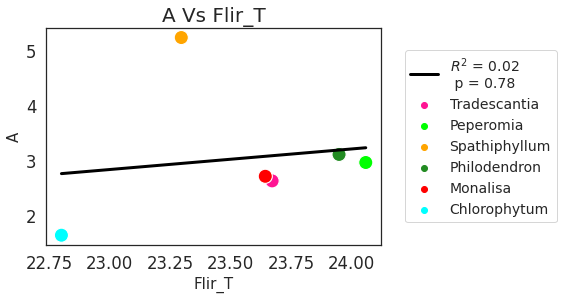

In [32]:
plot_2columns(df_group_avg,'Flir_T','E')
plot_2columns(df_group_avg,'Flir_T','A')